In [2]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Helper Functions
from helpers import *

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
import os

In [24]:
def crop(image, x1, x2, y1, y2):
    height = image.shape[0]
    width = image.shape[1]
    cropped = image[y1:y2, x1:x2]
    return cropped.copy()


def flip_img(img, direction):
    return cv2.flip(img, direction).copy()


def resize_with_pad(image, height=1500, width=1500):

    def get_padding_size(image):
        try:
            h, w, _ = image.shape
        except:
            h, w = image.shape
        longest_edge = max(h, w)
        top, bottom, left, right = (0, 0, 0, 0)
        if h < longest_edge:
            dh = longest_edge - h
            top = dh // 2
            bottom = dh - top
        elif w < longest_edge:
            dw = longest_edge - w
            left = dw // 2
            right = dw - left
        else:
            pass
    
        return top+100, bottom+100, left+100, right+100

    top, bottom, left, right = get_padding_size(image)
    BLACK = [0, 0, 0]
    constant = cv2.copyMakeBorder(
        image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=BLACK)

    resized_image = cv2.resize(constant, (height, width))

    return resized_image

def kmean_segmentation(image, K, attempts):

    vectorized = image.reshape((-1, 3)).copy()
    vectorized = np.float32(vectorized)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

    ret, label, center = cv2.kmeans(
        vectorized, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    image_kmean = res.reshape((image.shape))

    return image_kmean.copy()


def adaptive_thresholding(image_gray):
    # blur and grayscale before thresholding
    k = 3
    blur = cv2.GaussianBlur(
        src=image_gray,
        ksize=(k, k),
        sigmaX=0)

    # perform adaptive thresholding
    (t, image_thres) = cv2.threshold(src=blur,
                                     thresh=5,
                                     maxval=255,
                                     type=cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return image_thres.copy()


def get_contours(image, image_thres):
    image_with_cnts = image.copy()

    image_thres = cv2.erode(image_thres, None, iterations=2)
    image_thres = cv2.dilate(image_thres, None, iterations=2)

    cnts = cv2.findContours(image_thres, cv2.RETR_TREE,
                            cv2.CHAIN_APPROX_SIMPLE)[1]
    cv2.drawContours(image_with_cnts, cnts, -1, (0, 255, 255), 5)

    return image_with_cnts, cnts


def crop_by_contour(image, cnts):
    min_area = 30000
    max_area = 2000000
    box = np.zeros(shape=image.shape, dtype="uint8")
    for c in cnts:
        area = cv2.contourArea(c)
        if area > min_area and area < max_area:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(img=box,
                          pt1=(x, y),
                          pt2=(x + w, y + h),
                          color=(255, 255, 255),
                          thickness=-1)

    boxed = cv2.bitwise_and(src1=image, src2=box)
    image_cropped = image[y:y+h, x:x+w]

    return box, boxed, image_cropped

In [7]:
# Read all images
import os

blocks = []

path = './img_raw/blocks/'
files = os.listdir(path)
for index, file in enumerate(files):
    # convert image from BGR to RGB
    img_blk = cv2.cvtColor(cv2.imread(os.path.join(path, file)), cv2.COLOR_BGR2RGB)
    blocks.append(img_blk)

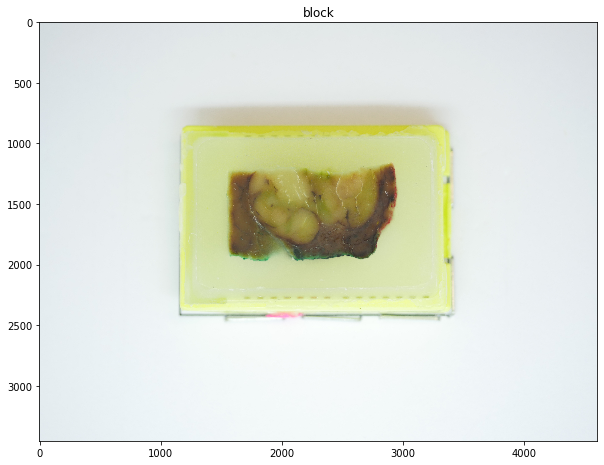

In [9]:
show1img(blocks[10], "block")

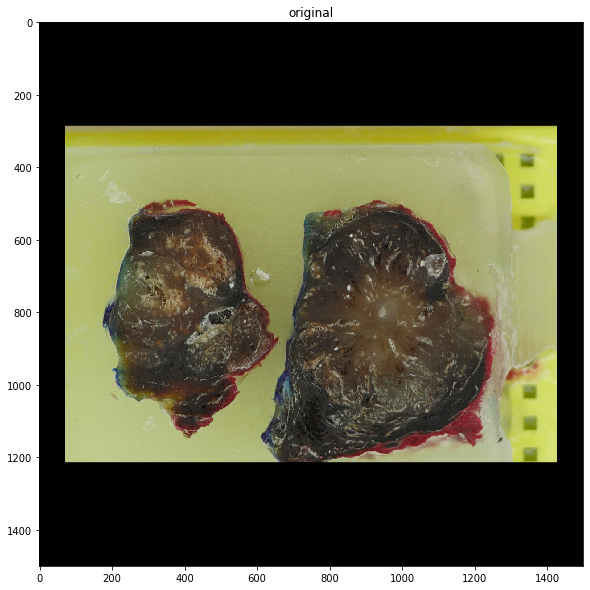

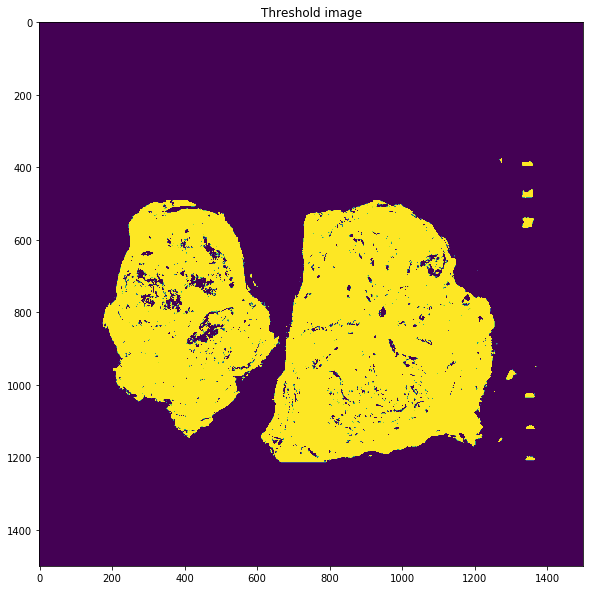

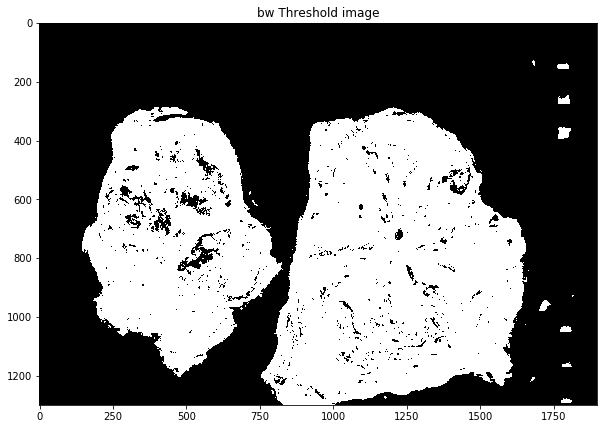

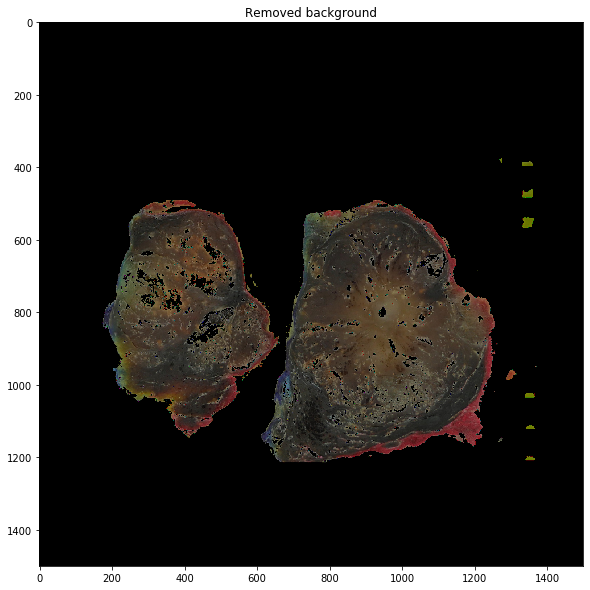

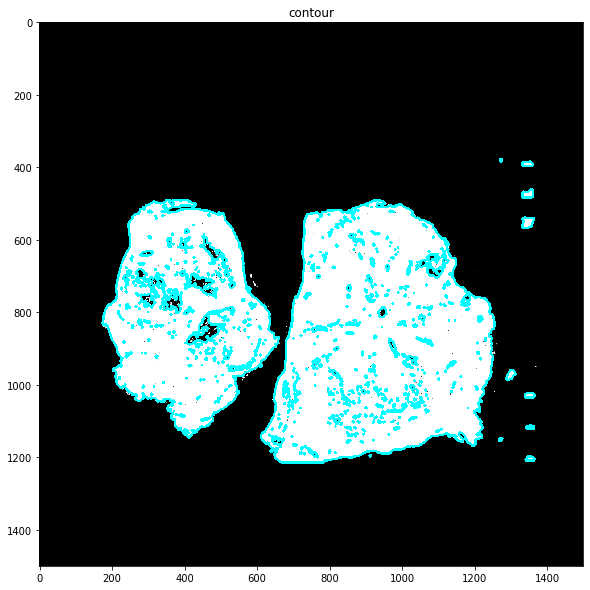

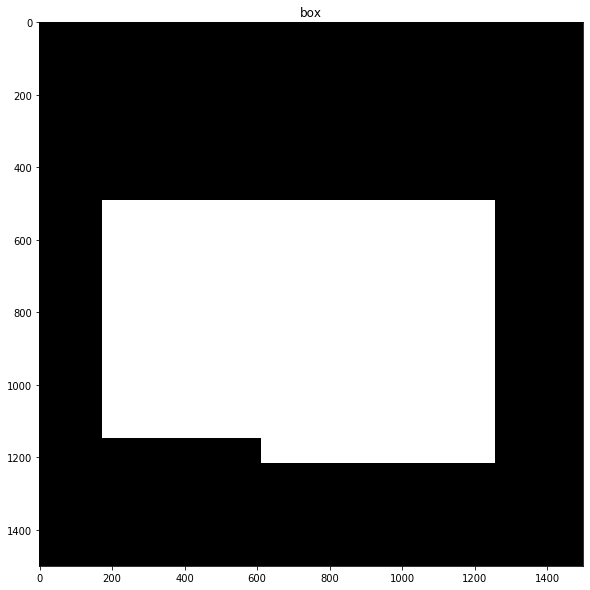

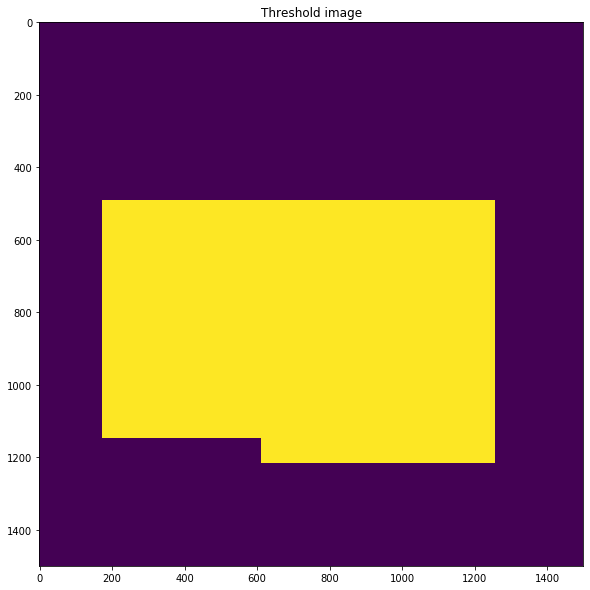

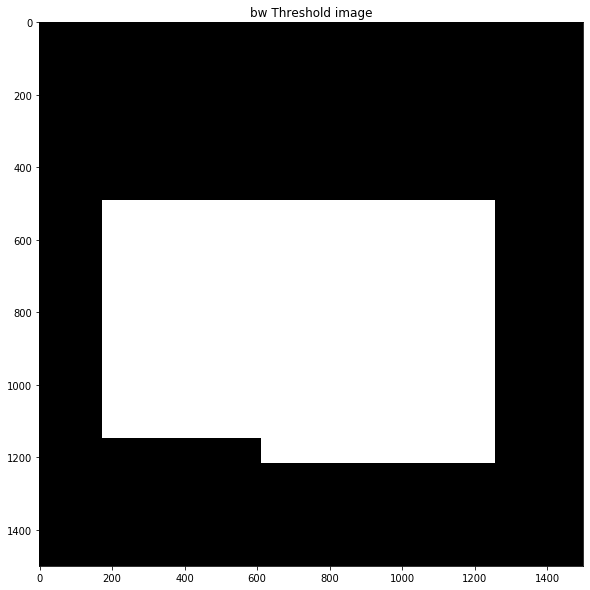

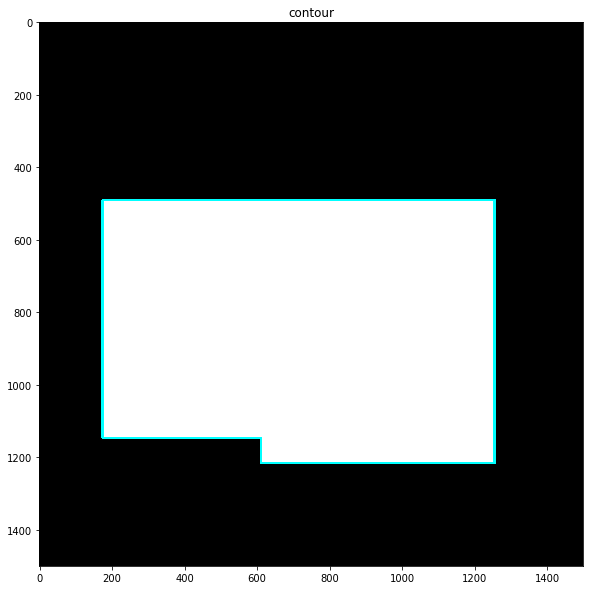

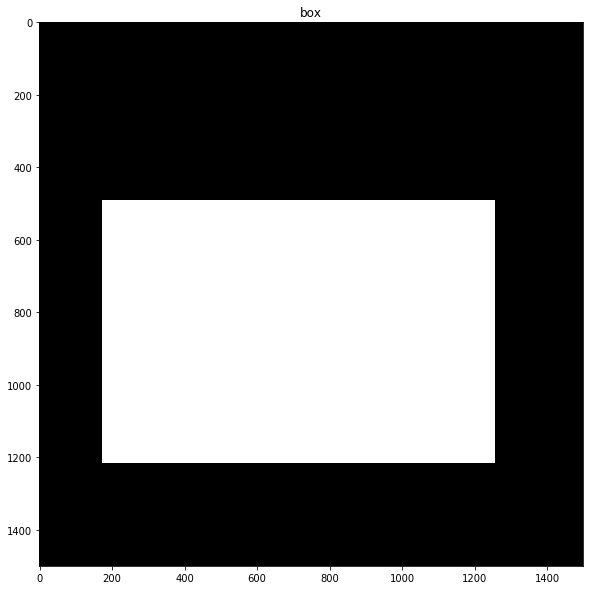

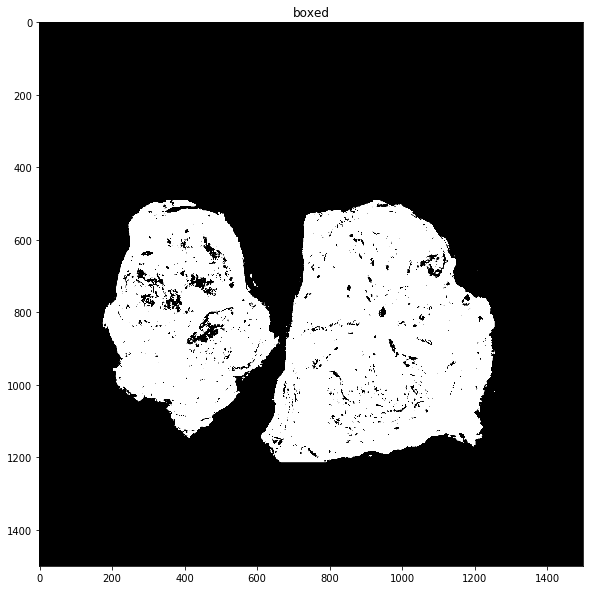

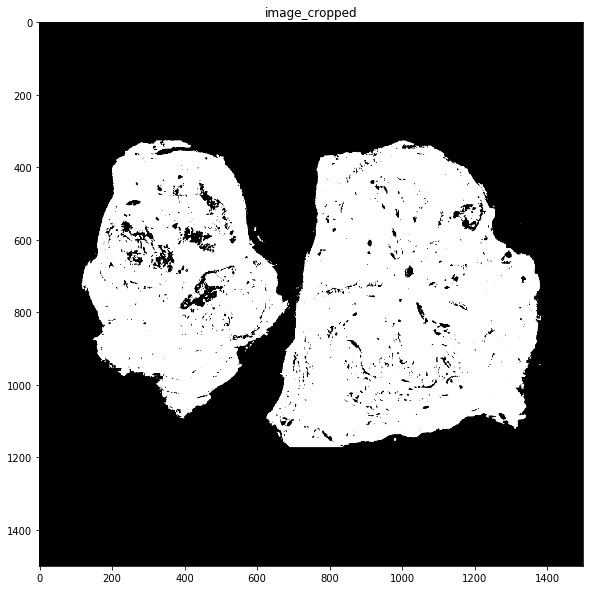

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [25]:
def preprocess_block(img_block, if_print):
    image = crop(img_block, 1300, 3200, 1000, 2300)

    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Adaptive thresholding
    image_thres = adaptive_thresholding(image_gray)
    image_thres = 255 - image_thres

    # Make a mask suitable for color images
    image_thres_bw = cv2.merge(mv=[image_thres, image_thres, image_thres])
    
    image_binary = image_thres_bw

    image = resize_with_pad(image, height=1500, width=1500)
    image_thres = resize_with_pad(image_thres, height=1500, width=1500)
    image_binary = resize_with_pad(image_binary, height=1500, width=1500)

    # Use the mask to select the remove background
    image_noBg = cv2.bitwise_and(src1=image, src2=image_binary)
    image_noBg[image_noBg == 0] = 0

    image_with_cnts, cnts = get_contours(image_binary, image_thres)

    # Find largest bounding rectangle
    box, boxed, image_cropped = crop_by_contour(image_binary, cnts)
    image_gray_box = cv2.cvtColor(box, cv2.COLOR_RGB2GRAY)
    # Adaptive thresholding
    image_thres_box = adaptive_thresholding(image_gray_box)

    # make a mask suitable for color images
    image_thres_bw_box = cv2.merge(
        mv=[image_thres_box, image_thres_box, image_thres_box])

    image_with_cnts_box, cnts_box = get_contours(box, image_thres_box)
    new_box, new_boxed, image_out = crop_by_contour(image_binary, cnts_box)

    image_out = resize_with_pad(image_out, height=1500, width=1500)

    if if_print:
        show1img(image, 'original')
        show1img(image_thres, 'Threshold image')
        show1img(image_thres_bw, 'bw Threshold image')
        show1img(image_noBg, 'Removed background')
        show1img(image_with_cnts, 'contour')
        show1img(box, 'box')
        show1img(image_thres_box, 'Threshold image')
        show1img(image_thres_bw_box, 'bw Threshold image')
        show1img(image_with_cnts_box, 'contour')
        show1img(new_box, 'box')
        show1img(new_boxed, 'boxed')
        show1img(image_out, 'image_cropped')

    return image_out

preprocess_block(blocks[11], True)